### Original source  
https://github.com/LeonardoBerti00/TABL-Temporal-Attention-Augmented-Bilinear-Network-for-Financial-Time-Series-Data-Analysis

### **TABL**

In [1]:
# load packages

import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from tqdm import tqdm 
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
import torch
from torch.utils import data
import torch.nn as nn
import torch.optim as optim

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


### **Data**
The dataset in the folder Dataset is the FI-2010 dataset zipped and normalized. 

As in the original paper I used the firs 7 days to train and to validate, and the rest 3 days to do the the testing. 

In [2]:
# please change the data_path to your local path and download the files you need from the web site of the dataset

dec_data = np.loadtxt('data/FI-2010/BenchmarkDatasets/NoAuction/1.NoAuction_Zscore/NoAuction_Zscore_Training/Train_Dst_NoAuction_ZScore_CF_7.txt')
dec_train = dec_data[:, :int(dec_data.shape[1] * 0.8)]
dec_val = dec_data[:, int(dec_data.shape[1] * 0.8):]

dec_test1 = np.loadtxt('data/FI-2010/BenchmarkDatasets/NoAuction/1.NoAuction_Zscore/NoAuction_Zscore_Testing/Test_Dst_NoAuction_ZScore_CF_7.txt')
dec_test2 = np.loadtxt('data/FI-2010/BenchmarkDatasets/NoAuction/1.NoAuction_Zscore/NoAuction_Zscore_Testing/Test_Dst_NoAuction_ZScore_CF_8.txt')
dec_test3 = np.loadtxt('data/FI-2010/BenchmarkDatasets/NoAuction/1.NoAuction_Zscore/NoAuction_Zscore_Testing/Test_Dst_NoAuction_ZScore_CF_9.txt')
dec_test = np.hstack((dec_test1, dec_test2, dec_test3))

h = 2        #if h = 2, than horizon = 50
T = 50      #horizon 
dim = 10

y_train = dec_train[-h, :].flatten()
y_val = dec_val[-h, :].flatten()
y_test = dec_test[-h, :].flatten()

y_train = y_train[dim-1:] - 1
y_val = y_val[dim-1:] - 1
y_test = y_test[dim-1:] - 1 

dec_train = dec_train[:40, :].T
dec_val = dec_val[:40, :].T
dec_test = dec_test[:40, :].T

In [3]:
#computing the weights for the weighted cross entropy loss
def compute_weights(y):
  cont_0 = 0
  cont_1 = 0
  cont_2 = 0
  for i in range(y.shape[0]):
    if (y[i] == 0):
      cont_0 += 1
    elif (y[i] == 1):
      cont_1 += 1
    elif (y[i] == 2):
      cont_2 += 2
    else: 
      raise Exception("wrong labels")
  return torch.Tensor([1e6/cont_0, 1e6/cont_1, 1e6/cont_2]).to(device)

y_total = np.concatenate((y_train, y_val, y_test))
weights = compute_weights(y_total)

In [4]:
class Dataset(data.Dataset):
    """Characterizes a dataset for PyTorch"""
    def __init__(self, x, y, num_classes, dim):
        """Initialization""" 
        self.num_classes = num_classes
        self.dim = dim
        self.x = x   
        self.y = y

        self.length = x.shape[0] - (T/10) -self.dim + 1
        print(self.length)

        x = torch.from_numpy(x)
        self.x = torch.unsqueeze(x, 1)
        self.y = torch.from_numpy(y)

    def __len__(self):
        """Denotes the total number of samples"""
        return int(self.length)

    def __getitem__(self, i):
        input = self.x[i:i+self.dim, :]
        input = input.permute(1, 2, 0)
        input = torch.squeeze(input)

        return input, self.y[i]

In [5]:
#Hyperparameters
batch_size = 256
epochs = 200
   
lr = 0.01
num_classes = 3
dim = 10

dataset_val = Dataset(dec_val, y_val, num_classes, dim)
dataset_test = Dataset(dec_test, y_test, num_classes, dim)
dataset_train = Dataset(dec_train, y_train, num_classes, dim)

train_loader = torch.utils.data.DataLoader(dataset=dataset_train, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(dataset=dataset_val, batch_size=batch_size, shuffle=False)
test_loader = torch.utils.data.DataLoader(dataset=dataset_test, batch_size=batch_size, shuffle=False)

50936.0
139573.0
203786.0


### **Model Architecture**


In [9]:
class TABL_layer(nn.Module):
    def __init__(self, d2, d1, t1, t2):
        super().__init__()
        self.t1 = t1

        weight = torch.Tensor(d2, d1)
        self.W1 = nn.Parameter(weight)
        nn.init.kaiming_uniform_(self.W1, nonlinearity='relu')
        
        weight2 = torch.Tensor(t1, t1)
        self.W = nn.Parameter(weight2)
        nn.init.constant_(self.W, 1/t1)
 
        weight3 = torch.Tensor(t1, t2)
        self.W2 = nn.Parameter(weight3)
        nn.init.kaiming_uniform_(self.W2, nonlinearity='relu')

        bias1 = torch.Tensor(d2, t2)
        self.B = nn.Parameter(bias1)
        nn.init.constant_(self.B, 0)

        l = torch.Tensor(1,)
        self.l = nn.Parameter(l)
        nn.init.constant_(self.l, 0.5)

        self.activation = nn.ReLU()

    def forward(self, X):
        
        #maintaining the weight parameter between 0 and 1.
        if (self.l[0] < 0): 
          l = torch.Tensor(1,)
          self.l = nn.Parameter(l)
          nn.init.constant_(self.l, 0.0)

        if (self.l[0] > 1): 
          l = torch.Tensor(1,)
          self.l = nn.Parameter(l)
          nn.init.constant_(self.l, 1.0)
     
        #modelling the dependence along the first mode of X while keeping the temporal order intact (7)
        X = self.W1 @ X

        #enforcing constant (1) on the diagonal
        W = self.W -self.W *torch.eye(self.t1,dtype=torch.float32).to(device)+torch.eye(self.t1,dtype=torch.float32).to(device)/self.t1

        #attention, the aim of the second step is to learn how important the temporal instances are to each other (8)
        E = X @ W

        #computing the attention mask  (9)
        A = torch.softmax(E, dim=-1)

        #applying a soft attention mechanism  (10)
        #he attention mask A obtained from the third step is used to zero out the effect of unimportant elements
        X = self.l[0] * (X) + (1.0 - self.l[0])*X*A

        #the final step of the proposed layer estimates the temporal mapping W2, after the bias shift (11)
        y = X @ self.W2 + self.B
        return y

class BL_layer(nn.Module):
  def __init__(self, d2, d1, t1, t2):
        super().__init__()
        weight1 = torch.Tensor(d2, d1)
        self.W1 = nn.Parameter(weight1)
        nn.init.kaiming_uniform_(self.W1, nonlinearity='relu')

        weight2 = torch.Tensor(t1, t2)
        self.W2 = nn.Parameter(weight2)
        nn.init.kaiming_uniform_(self.W2, nonlinearity='relu')

        bias1 = torch.zeros((d2, t2))
        self.B = nn.Parameter(bias1)
        nn.init.constant_(self.B, 0)

        self.activation = nn.ReLU()

  def forward(self, x):

    x = self.activation(self.W1 @ x @ self.W2 + self.B)

    return x


class BTABL(nn.Module):
  def __init__(self, d2, d1, t1, t2, d3, t3):
    super().__init__()

    self.BL = BL_layer(d2, d1, t1, t2)
    self.TABL = TABL_layer(d3, d2, t2, t3)
    self.dropout = nn.Dropout(0.1)

  def forward(self, x):

    self.max_norm_(self.BL.W1.data)
    self.max_norm_(self.BL.W2.data)
    x = self.BL(x)
    x = self.dropout(x)

    self.max_norm_(self.TABL.W1.data)
    self.max_norm_(self.TABL.W.data)
    self.max_norm_(self.TABL.W2.data)
    x = self.TABL(x)
    x = torch.squeeze(x)
    x = torch.softmax(x, 1)
    return x

  def max_norm_(self, w):
    with torch.no_grad():
      if (torch.linalg.matrix_norm(w) > 10.0):
        norm = torch.linalg.matrix_norm(w)
        desired = torch.clamp(norm, min=0.0, max=10.0)
        w *= (desired / (1e-8 + norm))



class CTABL(nn.Module):
  def __init__(self, d2, d1, t1, t2, d3, t3, d4, t4):
    super().__init__()
    
    self.BL = BL_layer(d2, d1, t1, t2)
    self.BL2 = BL_layer(d3, d2, t2, t3)
    self.TABL = TABL_layer(d4, d3, t3, t4)
    self.dropout = nn.Dropout(0.1)

  def forward(self, x):
 
    self.max_norm_(self.BL.W1.data)
    self.max_norm_(self.BL.W2.data)
    x = self.BL(x)
    x = self.dropout(x)

    self.max_norm_(self.BL2.W1.data)
    self.max_norm_(self.BL2.W2.data)
    x = self.BL2(x)
    x = self.dropout(x)

    self.max_norm_(self.TABL.W1.data)
    self.max_norm_(self.TABL.W.data)
    self.max_norm_(self.TABL.W2.data)
    x = self.TABL(x)
    x = torch.squeeze(x)
    x = torch.softmax(x, 1)
    return x

  def max_norm_(self, w):
    with torch.no_grad():
      if (torch.linalg.matrix_norm(w) > 10.0):
        norm = torch.linalg.matrix_norm(w)
        desired = torch.clamp(norm, min=0.0, max=10.0)
        w *= (desired / (1e-8 + norm))
    

### **Model Training**

I implemented the second setting of the experiment

In [12]:
#Choose between B(TABL) and C(TABL)

#model = BTABL(120, 40, 10, 5, 3, 1)
model = CTABL(60, 40, 10, 10, 120, 5, 3, 1)

model.to(device)

criterion = nn.CrossEntropyLoss(weight=weights)
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

def batch_gd(model, criterion, optimizer, epochs):
    
    train_losses = np.zeros(epochs)
    test_losses = np.zeros(epochs)
    best_test_loss = np.inf
    best_test_epoch = 0
    SC = [0.005, 0.001, 0.0005, 0.0001]
    i = 0
    for it in tqdm(range(epochs)):
        
        model.train()
        t0 = datetime.now()
        train_loss = []
        for inputs, targets in train_loader:
            # move data to GPU
            inputs, targets = inputs.to(device, dtype=torch.float), targets.to(device, dtype=torch.int64)

            # zero the parameter gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, targets)

            # Backward and optimize
            loss.backward()
            optimizer.step()

            train_loss.append(loss.item())
        # Get train loss and test loss
        train_loss = np.mean(train_loss)
        
        if (train_losses[it-1] <= train_loss and i < 4 and it != 0):
              for g in optimizer.param_groups:
                g['lr'] = SC[i]
              i += 1
              

        model.eval()
        test_loss = []
        for inputs, targets in val_loader:
            inputs, targets = inputs.to(device, dtype=torch.float), targets.to(device, dtype=torch.int64)      
            outputs = model(inputs)
            #outputs = torch.squeeze(outputs)
            loss = criterion(outputs, targets)
            test_loss.append(loss.item())
        test_loss = np.mean(test_loss)

        # Save losses
        train_losses[it] = train_loss
        test_losses[it] = test_loss
        
        #We save the best model
        if test_loss < best_test_loss:
            torch.save(model, './best_model_CTABL')
            best_test_loss = test_loss
            best_test_epoch = it
            print('model saved')

        dt = datetime.now() - t0
        print(f'Epoch {it+1}/{epochs}, Train Loss: {train_loss:.4f}, \
          Validation Loss: {test_loss:.4f}, Duration: {dt}, Best Val Epoch: {best_test_epoch}')
        
    #torch.save(model, '/content/drive/MyDrive/Output/best_model_translob_FI')
    return train_losses, test_losses

------- List Hyper Parameters -------
epochs   ->   200
learningRate   ->   0.01
horizon    ->     50
batch size   ->    256
Optimizer   ->    SGD (
Parameter Group 0
    dampening: 0
    differentiable: False
    foreach: None
    lr: 0.01
    maximize: False
    momentum: 0.9
    nesterov: False
    weight_decay: 0
)


  0%|▍                                                                            | 1/200 [00:06<22:03,  6.65s/it]

model saved
Epoch 1/200, Train Loss: 1.0430,           Validation Loss: 0.9936, Duration: 0:00:06.648256, Best Val Epoch: 0


  1%|▊                                                                            | 2/200 [00:13<22:03,  6.68s/it]

model saved
Epoch 2/200, Train Loss: 0.9484,           Validation Loss: 0.9895, Duration: 0:00:06.707490, Best Val Epoch: 1


  2%|█▏                                                                           | 3/200 [00:19<21:51,  6.66s/it]

model saved
Epoch 3/200, Train Loss: 0.9167,           Validation Loss: 0.9747, Duration: 0:00:06.621504, Best Val Epoch: 2


  2%|█▌                                                                           | 4/200 [00:26<21:52,  6.70s/it]

model saved
Epoch 4/200, Train Loss: 0.9021,           Validation Loss: 0.9676, Duration: 0:00:06.764269, Best Val Epoch: 3


  2%|█▉                                                                           | 5/200 [00:33<21:23,  6.58s/it]

model saved
Epoch 5/200, Train Loss: 0.8904,           Validation Loss: 0.9622, Duration: 0:00:06.374991, Best Val Epoch: 4


  3%|██▎                                                                          | 6/200 [00:39<21:09,  6.54s/it]

model saved
Epoch 6/200, Train Loss: 0.8811,           Validation Loss: 0.9502, Duration: 0:00:06.468365, Best Val Epoch: 5


  4%|██▋                                                                          | 7/200 [00:46<21:40,  6.74s/it]

Epoch 7/200, Train Loss: 0.8731,           Validation Loss: 0.9559, Duration: 0:00:07.143568, Best Val Epoch: 5


  4%|███                                                                          | 8/200 [00:53<21:35,  6.74s/it]

model saved
Epoch 8/200, Train Loss: 0.8674,           Validation Loss: 0.9419, Duration: 0:00:06.754482, Best Val Epoch: 7


  4%|███▍                                                                         | 9/200 [01:00<21:17,  6.69s/it]

model saved
Epoch 9/200, Train Loss: 0.8624,           Validation Loss: 0.9374, Duration: 0:00:06.571031, Best Val Epoch: 8


  5%|███▊                                                                        | 10/200 [01:06<21:13,  6.70s/it]

model saved
Epoch 10/200, Train Loss: 0.8571,           Validation Loss: 0.9309, Duration: 0:00:06.732012, Best Val Epoch: 9


  6%|████▏                                                                       | 11/200 [01:13<20:59,  6.66s/it]

model saved
Epoch 11/200, Train Loss: 0.8535,           Validation Loss: 0.9260, Duration: 0:00:06.568124, Best Val Epoch: 10


  6%|████▌                                                                       | 12/200 [01:19<20:40,  6.60s/it]

Epoch 12/200, Train Loss: 0.8497,           Validation Loss: 0.9325, Duration: 0:00:06.450636, Best Val Epoch: 10


  6%|████▉                                                                       | 13/200 [01:26<20:40,  6.63s/it]

model saved
Epoch 13/200, Train Loss: 0.8467,           Validation Loss: 0.9205, Duration: 0:00:06.715112, Best Val Epoch: 12


  7%|█████▎                                                                      | 14/200 [01:33<20:51,  6.73s/it]

Epoch 14/200, Train Loss: 0.8437,           Validation Loss: 0.9249, Duration: 0:00:06.940257, Best Val Epoch: 12


  8%|█████▋                                                                      | 15/200 [01:40<20:58,  6.80s/it]

model saved
Epoch 15/200, Train Loss: 0.8412,           Validation Loss: 0.9126, Duration: 0:00:06.977538, Best Val Epoch: 14


  8%|██████                                                                      | 16/200 [01:47<20:42,  6.75s/it]

model saved
Epoch 16/200, Train Loss: 0.8381,           Validation Loss: 0.9093, Duration: 0:00:06.635458, Best Val Epoch: 15


  8%|██████▍                                                                     | 17/200 [01:53<20:12,  6.63s/it]

model saved
Epoch 17/200, Train Loss: 0.8362,           Validation Loss: 0.9082, Duration: 0:00:06.332897, Best Val Epoch: 16


  9%|██████▊                                                                     | 18/200 [01:59<19:44,  6.51s/it]

Epoch 18/200, Train Loss: 0.8343,           Validation Loss: 0.9199, Duration: 0:00:06.239705, Best Val Epoch: 16


 10%|███████▏                                                                    | 19/200 [02:06<19:43,  6.54s/it]

Epoch 19/200, Train Loss: 0.8323,           Validation Loss: 0.9087, Duration: 0:00:06.602624, Best Val Epoch: 16


 10%|███████▌                                                                    | 20/200 [02:12<19:30,  6.50s/it]

model saved
Epoch 20/200, Train Loss: 0.8301,           Validation Loss: 0.9009, Duration: 0:00:06.414729, Best Val Epoch: 19


 10%|███████▉                                                                    | 21/200 [02:19<19:30,  6.54s/it]

Epoch 21/200, Train Loss: 0.8278,           Validation Loss: 0.9063, Duration: 0:00:06.632488, Best Val Epoch: 19


 11%|████████▎                                                                   | 22/200 [02:26<19:45,  6.66s/it]

Epoch 22/200, Train Loss: 0.8268,           Validation Loss: 0.9029, Duration: 0:00:06.938302, Best Val Epoch: 19


 12%|████████▋                                                                   | 23/200 [02:32<19:27,  6.60s/it]

Epoch 23/200, Train Loss: 0.8255,           Validation Loss: 0.9075, Duration: 0:00:06.448932, Best Val Epoch: 19


 12%|█████████                                                                   | 24/200 [02:39<19:16,  6.57s/it]

Epoch 24/200, Train Loss: 0.8236,           Validation Loss: 0.9035, Duration: 0:00:06.510923, Best Val Epoch: 19


 12%|█████████▌                                                                  | 25/200 [02:45<19:16,  6.61s/it]

model saved
Epoch 25/200, Train Loss: 0.8224,           Validation Loss: 0.8937, Duration: 0:00:06.691874, Best Val Epoch: 24


 13%|█████████▉                                                                  | 26/200 [02:52<19:11,  6.62s/it]

model saved
Epoch 26/200, Train Loss: 0.8208,           Validation Loss: 0.8911, Duration: 0:00:06.631015, Best Val Epoch: 25


 14%|██████████▎                                                                 | 27/200 [02:59<19:42,  6.84s/it]

Epoch 27/200, Train Loss: 0.8194,           Validation Loss: 0.8941, Duration: 0:00:07.350258, Best Val Epoch: 25


 14%|██████████▋                                                                 | 28/200 [03:06<19:19,  6.74s/it]

Epoch 28/200, Train Loss: 0.8179,           Validation Loss: 0.8958, Duration: 0:00:06.521472, Best Val Epoch: 25


 14%|███████████                                                                 | 29/200 [03:12<18:58,  6.66s/it]

model saved
Epoch 29/200, Train Loss: 0.8175,           Validation Loss: 0.8903, Duration: 0:00:06.456206, Best Val Epoch: 28


 15%|███████████▍                                                                | 30/200 [03:19<18:42,  6.60s/it]

Epoch 30/200, Train Loss: 0.8172,           Validation Loss: 0.8913, Duration: 0:00:06.469558, Best Val Epoch: 28


 16%|███████████▊                                                                | 31/200 [03:26<18:41,  6.64s/it]

Epoch 31/200, Train Loss: 0.8154,           Validation Loss: 0.9014, Duration: 0:00:06.715435, Best Val Epoch: 28


 16%|████████████▏                                                               | 32/200 [03:32<18:46,  6.70s/it]

Epoch 32/200, Train Loss: 0.8153,           Validation Loss: 0.8954, Duration: 0:00:06.865490, Best Val Epoch: 28


 16%|████████████▌                                                               | 33/200 [03:39<18:30,  6.65s/it]

Epoch 33/200, Train Loss: 0.8228,           Validation Loss: 0.8991, Duration: 0:00:06.518006, Best Val Epoch: 28


 17%|████████████▉                                                               | 34/200 [03:45<18:12,  6.58s/it]

model saved
Epoch 34/200, Train Loss: 0.8128,           Validation Loss: 0.8874, Duration: 0:00:06.431850, Best Val Epoch: 33


 18%|█████████████▎                                                              | 35/200 [03:52<17:53,  6.50s/it]

model saved
Epoch 35/200, Train Loss: 0.8122,           Validation Loss: 0.8851, Duration: 0:00:06.314666, Best Val Epoch: 34


 18%|█████████████▋                                                              | 36/200 [03:58<17:37,  6.45s/it]

model saved
Epoch 36/200, Train Loss: 0.8110,           Validation Loss: 0.8846, Duration: 0:00:06.321610, Best Val Epoch: 35


 18%|██████████████                                                              | 37/200 [04:05<17:53,  6.59s/it]

model saved
Epoch 37/200, Train Loss: 0.8105,           Validation Loss: 0.8845, Duration: 0:00:06.902948, Best Val Epoch: 36


 19%|██████████████▍                                                             | 38/200 [04:11<17:44,  6.57s/it]

model saved
Epoch 38/200, Train Loss: 0.8106,           Validation Loss: 0.8842, Duration: 0:00:06.526072, Best Val Epoch: 37


 20%|██████████████▊                                                             | 39/200 [04:18<17:26,  6.50s/it]

model saved
Epoch 39/200, Train Loss: 0.8077,           Validation Loss: 0.8831, Duration: 0:00:06.342894, Best Val Epoch: 38


 20%|███████████████▏                                                            | 40/200 [04:24<17:22,  6.52s/it]

Epoch 40/200, Train Loss: 0.8078,           Validation Loss: 0.8838, Duration: 0:00:06.558749, Best Val Epoch: 38


 20%|███████████████▌                                                            | 41/200 [04:31<17:15,  6.51s/it]

Epoch 41/200, Train Loss: 0.8069,           Validation Loss: 0.8835, Duration: 0:00:06.495297, Best Val Epoch: 38


 21%|███████████████▉                                                            | 42/200 [04:37<17:08,  6.51s/it]

model saved
Epoch 42/200, Train Loss: 0.8068,           Validation Loss: 0.8824, Duration: 0:00:06.494586, Best Val Epoch: 41


 22%|████████████████▎                                                           | 43/200 [04:44<17:10,  6.56s/it]

model saved
Epoch 43/200, Train Loss: 0.8065,           Validation Loss: 0.8822, Duration: 0:00:06.690411, Best Val Epoch: 42


 22%|████████████████▋                                                           | 44/200 [04:51<17:13,  6.63s/it]

Epoch 44/200, Train Loss: 0.8066,           Validation Loss: 0.8830, Duration: 0:00:06.773122, Best Val Epoch: 42


 22%|█████████████████                                                           | 45/200 [04:58<17:11,  6.65s/it]

Epoch 45/200, Train Loss: 0.8060,           Validation Loss: 0.8827, Duration: 0:00:06.712583, Best Val Epoch: 42


 23%|█████████████████▍                                                          | 46/200 [05:04<17:19,  6.75s/it]

Epoch 46/200, Train Loss: 0.8059,           Validation Loss: 0.8827, Duration: 0:00:06.968326, Best Val Epoch: 42


 24%|█████████████████▊                                                          | 47/200 [05:11<16:57,  6.65s/it]

Epoch 47/200, Train Loss: 0.8061,           Validation Loss: 0.8826, Duration: 0:00:06.433906, Best Val Epoch: 42


 24%|██████████████████▏                                                         | 48/200 [05:18<16:48,  6.63s/it]

Epoch 48/200, Train Loss: 0.8058,           Validation Loss: 0.8827, Duration: 0:00:06.584072, Best Val Epoch: 42


 24%|██████████████████▌                                                         | 49/200 [05:24<16:48,  6.68s/it]

Epoch 49/200, Train Loss: 0.8064,           Validation Loss: 0.8825, Duration: 0:00:06.775476, Best Val Epoch: 42


 25%|███████████████████                                                         | 50/200 [05:31<16:52,  6.75s/it]

Epoch 50/200, Train Loss: 0.8058,           Validation Loss: 0.8822, Duration: 0:00:06.926856, Best Val Epoch: 42


 26%|███████████████████▍                                                        | 51/200 [05:38<16:32,  6.66s/it]

Epoch 51/200, Train Loss: 0.8058,           Validation Loss: 0.8824, Duration: 0:00:06.447390, Best Val Epoch: 42


 26%|███████████████████▊                                                        | 52/200 [05:44<16:12,  6.57s/it]

Epoch 52/200, Train Loss: 0.8058,           Validation Loss: 0.8824, Duration: 0:00:06.368678, Best Val Epoch: 42


 26%|████████████████████▏                                                       | 53/200 [05:51<16:14,  6.63s/it]

Epoch 53/200, Train Loss: 0.8061,           Validation Loss: 0.8826, Duration: 0:00:06.752290, Best Val Epoch: 42


 27%|████████████████████▌                                                       | 54/200 [05:57<16:00,  6.58s/it]

Epoch 54/200, Train Loss: 0.8061,           Validation Loss: 0.8824, Duration: 0:00:06.471009, Best Val Epoch: 42


 28%|████████████████████▉                                                       | 55/200 [06:04<15:56,  6.60s/it]

Epoch 55/200, Train Loss: 0.8061,           Validation Loss: 0.8822, Duration: 0:00:06.638931, Best Val Epoch: 42


 28%|█████████████████████▎                                                      | 56/200 [06:11<16:04,  6.70s/it]

Epoch 56/200, Train Loss: 0.8064,           Validation Loss: 0.8825, Duration: 0:00:06.927587, Best Val Epoch: 42


 28%|█████████████████████▋                                                      | 57/200 [06:18<16:02,  6.73s/it]

Epoch 57/200, Train Loss: 0.8059,           Validation Loss: 0.8825, Duration: 0:00:06.819522, Best Val Epoch: 42


 29%|██████████████████████                                                      | 58/200 [06:24<15:48,  6.68s/it]

Epoch 58/200, Train Loss: 0.8063,           Validation Loss: 0.8823, Duration: 0:00:06.552574, Best Val Epoch: 42


 30%|██████████████████████▍                                                     | 59/200 [06:31<15:41,  6.68s/it]

Epoch 59/200, Train Loss: 0.8062,           Validation Loss: 0.8824, Duration: 0:00:06.662961, Best Val Epoch: 42


 30%|██████████████████████▊                                                     | 60/200 [06:37<15:22,  6.59s/it]

Epoch 60/200, Train Loss: 0.8067,           Validation Loss: 0.8822, Duration: 0:00:06.387340, Best Val Epoch: 42


 30%|███████████████████████▏                                                    | 61/200 [06:44<15:38,  6.75s/it]

model saved
Epoch 61/200, Train Loss: 0.8062,           Validation Loss: 0.8822, Duration: 0:00:07.125224, Best Val Epoch: 60


 31%|███████████████████████▌                                                    | 62/200 [06:51<15:25,  6.71s/it]

Epoch 62/200, Train Loss: 0.8065,           Validation Loss: 0.8823, Duration: 0:00:06.611031, Best Val Epoch: 60


 32%|███████████████████████▉                                                    | 63/200 [06:58<15:16,  6.69s/it]

model saved
Epoch 63/200, Train Loss: 0.8055,           Validation Loss: 0.8821, Duration: 0:00:06.648805, Best Val Epoch: 62


 32%|████████████████████████▎                                                   | 64/200 [07:04<15:05,  6.66s/it]

model saved
Epoch 64/200, Train Loss: 0.8055,           Validation Loss: 0.8820, Duration: 0:00:06.581239, Best Val Epoch: 63


 32%|████████████████████████▋                                                   | 65/200 [07:10<14:40,  6.52s/it]

Epoch 65/200, Train Loss: 0.8056,           Validation Loss: 0.8821, Duration: 0:00:06.194918, Best Val Epoch: 63


 33%|█████████████████████████                                                   | 66/200 [07:17<14:41,  6.58s/it]

Epoch 66/200, Train Loss: 0.8059,           Validation Loss: 0.8822, Duration: 0:00:06.722606, Best Val Epoch: 63


 34%|█████████████████████████▍                                                  | 67/200 [07:24<14:50,  6.69s/it]

Epoch 67/200, Train Loss: 0.8058,           Validation Loss: 0.8821, Duration: 0:00:06.952031, Best Val Epoch: 63


 34%|█████████████████████████▊                                                  | 68/200 [07:31<14:39,  6.67s/it]

Epoch 68/200, Train Loss: 0.8059,           Validation Loss: 0.8823, Duration: 0:00:06.604395, Best Val Epoch: 63


 34%|██████████████████████████▏                                                 | 69/200 [07:37<14:36,  6.69s/it]

Epoch 69/200, Train Loss: 0.8055,           Validation Loss: 0.8821, Duration: 0:00:06.748238, Best Val Epoch: 63


 35%|██████████████████████████▌                                                 | 70/200 [07:44<14:37,  6.75s/it]

Epoch 70/200, Train Loss: 0.8056,           Validation Loss: 0.8822, Duration: 0:00:06.891371, Best Val Epoch: 63


 36%|██████████████████████████▉                                                 | 71/200 [07:51<14:27,  6.73s/it]

model saved
Epoch 71/200, Train Loss: 0.8064,           Validation Loss: 0.8820, Duration: 0:00:06.669091, Best Val Epoch: 70


 36%|███████████████████████████▎                                                | 72/200 [07:58<14:15,  6.69s/it]

Epoch 72/200, Train Loss: 0.8061,           Validation Loss: 0.8820, Duration: 0:00:06.593160, Best Val Epoch: 70


 36%|███████████████████████████▋                                                | 73/200 [08:04<13:53,  6.56s/it]

Epoch 73/200, Train Loss: 0.8063,           Validation Loss: 0.8824, Duration: 0:00:06.266509, Best Val Epoch: 70


 37%|████████████████████████████                                                | 74/200 [08:11<14:06,  6.72s/it]

Epoch 74/200, Train Loss: 0.8062,           Validation Loss: 0.8820, Duration: 0:00:07.079291, Best Val Epoch: 70


 38%|████████████████████████████▌                                               | 75/200 [08:18<14:05,  6.76s/it]

Epoch 75/200, Train Loss: 0.8059,           Validation Loss: 0.8821, Duration: 0:00:06.871815, Best Val Epoch: 70


 38%|████████████████████████████▉                                               | 76/200 [08:25<14:00,  6.78s/it]

model saved
Epoch 76/200, Train Loss: 0.8058,           Validation Loss: 0.8818, Duration: 0:00:06.808015, Best Val Epoch: 75


 38%|█████████████████████████████▎                                              | 77/200 [08:31<13:49,  6.74s/it]

Epoch 77/200, Train Loss: 0.8063,           Validation Loss: 0.8820, Duration: 0:00:06.668055, Best Val Epoch: 75


 39%|█████████████████████████████▋                                              | 78/200 [08:38<13:53,  6.83s/it]

Epoch 78/200, Train Loss: 0.8064,           Validation Loss: 0.8820, Duration: 0:00:07.032095, Best Val Epoch: 75


 40%|██████████████████████████████                                              | 79/200 [08:45<13:39,  6.78s/it]

Epoch 79/200, Train Loss: 0.8056,           Validation Loss: 0.8823, Duration: 0:00:06.645251, Best Val Epoch: 75


 40%|██████████████████████████████▍                                             | 80/200 [08:51<13:23,  6.70s/it]

Epoch 80/200, Train Loss: 0.8054,           Validation Loss: 0.8820, Duration: 0:00:06.510975, Best Val Epoch: 75


 40%|██████████████████████████████▊                                             | 81/200 [08:58<13:17,  6.70s/it]

model saved
Epoch 81/200, Train Loss: 0.8053,           Validation Loss: 0.8816, Duration: 0:00:06.722494, Best Val Epoch: 80


 41%|███████████████████████████████▏                                            | 82/200 [09:05<12:57,  6.59s/it]

Epoch 82/200, Train Loss: 0.8058,           Validation Loss: 0.8819, Duration: 0:00:06.325837, Best Val Epoch: 80


 42%|███████████████████████████████▌                                            | 83/200 [09:11<13:00,  6.67s/it]

Epoch 83/200, Train Loss: 0.8060,           Validation Loss: 0.8817, Duration: 0:00:06.847721, Best Val Epoch: 80


 42%|███████████████████████████████▉                                            | 84/200 [09:19<13:12,  6.83s/it]

Epoch 84/200, Train Loss: 0.8065,           Validation Loss: 0.8819, Duration: 0:00:07.216888, Best Val Epoch: 80


 42%|████████████████████████████████▎                                           | 85/200 [09:25<12:51,  6.71s/it]

Epoch 85/200, Train Loss: 0.8057,           Validation Loss: 0.8819, Duration: 0:00:06.405177, Best Val Epoch: 80


 43%|████████████████████████████████▋                                           | 86/200 [09:31<12:36,  6.64s/it]

Epoch 86/200, Train Loss: 0.8059,           Validation Loss: 0.8822, Duration: 0:00:06.480860, Best Val Epoch: 80


 44%|█████████████████████████████████                                           | 87/200 [09:38<12:42,  6.74s/it]

Epoch 87/200, Train Loss: 0.8058,           Validation Loss: 0.8822, Duration: 0:00:06.990653, Best Val Epoch: 80


 44%|█████████████████████████████████▍                                          | 88/200 [09:45<12:42,  6.81s/it]

Epoch 88/200, Train Loss: 0.8057,           Validation Loss: 0.8818, Duration: 0:00:06.957257, Best Val Epoch: 80


 44%|█████████████████████████████████▊                                          | 89/200 [09:52<12:26,  6.73s/it]

Epoch 89/200, Train Loss: 0.8056,           Validation Loss: 0.8820, Duration: 0:00:06.536230, Best Val Epoch: 80


 45%|██████████████████████████████████▏                                         | 90/200 [09:59<12:26,  6.79s/it]

Epoch 90/200, Train Loss: 0.8057,           Validation Loss: 0.8820, Duration: 0:00:06.921463, Best Val Epoch: 80


 46%|██████████████████████████████████▌                                         | 91/200 [10:05<12:02,  6.63s/it]

Epoch 91/200, Train Loss: 0.8058,           Validation Loss: 0.8820, Duration: 0:00:06.272593, Best Val Epoch: 80


 46%|██████████████████████████████████▉                                         | 92/200 [10:12<11:58,  6.66s/it]

Epoch 92/200, Train Loss: 0.8057,           Validation Loss: 0.8820, Duration: 0:00:06.709912, Best Val Epoch: 80


 46%|███████████████████████████████████▎                                        | 93/200 [10:18<11:42,  6.56s/it]

Epoch 93/200, Train Loss: 0.8056,           Validation Loss: 0.8820, Duration: 0:00:06.348902, Best Val Epoch: 80


 47%|███████████████████████████████████▋                                        | 94/200 [10:24<11:22,  6.44s/it]

Epoch 94/200, Train Loss: 0.8058,           Validation Loss: 0.8822, Duration: 0:00:06.144063, Best Val Epoch: 80


 48%|████████████████████████████████████                                        | 95/200 [10:31<11:21,  6.49s/it]

Epoch 95/200, Train Loss: 0.8051,           Validation Loss: 0.8819, Duration: 0:00:06.599690, Best Val Epoch: 80


 48%|████████████████████████████████████▍                                       | 96/200 [10:38<11:37,  6.71s/it]

Epoch 96/200, Train Loss: 0.8059,           Validation Loss: 0.8822, Duration: 0:00:07.216428, Best Val Epoch: 80


 48%|████████████████████████████████████▊                                       | 97/200 [10:45<11:25,  6.65s/it]

Epoch 97/200, Train Loss: 0.8053,           Validation Loss: 0.8820, Duration: 0:00:06.520715, Best Val Epoch: 80


 49%|█████████████████████████████████████▏                                      | 98/200 [10:51<11:20,  6.67s/it]

Epoch 98/200, Train Loss: 0.8055,           Validation Loss: 0.8818, Duration: 0:00:06.730761, Best Val Epoch: 80


 50%|█████████████████████████████████████▌                                      | 99/200 [10:58<11:17,  6.71s/it]

Epoch 99/200, Train Loss: 0.8056,           Validation Loss: 0.8818, Duration: 0:00:06.799581, Best Val Epoch: 80


 50%|█████████████████████████████████████▌                                     | 100/200 [11:05<11:12,  6.72s/it]

model saved
Epoch 100/200, Train Loss: 0.8058,           Validation Loss: 0.8816, Duration: 0:00:06.741738, Best Val Epoch: 99


 50%|█████████████████████████████████████▉                                     | 101/200 [11:12<11:05,  6.73s/it]

Epoch 101/200, Train Loss: 0.8055,           Validation Loss: 0.8818, Duration: 0:00:06.736421, Best Val Epoch: 99


 51%|██████████████████████████████████████▎                                    | 102/200 [11:19<11:02,  6.76s/it]

Epoch 102/200, Train Loss: 0.8055,           Validation Loss: 0.8819, Duration: 0:00:06.829412, Best Val Epoch: 99


 52%|██████████████████████████████████████▋                                    | 103/200 [11:25<10:51,  6.72s/it]

Epoch 103/200, Train Loss: 0.8058,           Validation Loss: 0.8819, Duration: 0:00:06.622074, Best Val Epoch: 99


 52%|███████████████████████████████████████                                    | 104/200 [11:32<10:37,  6.64s/it]

Epoch 104/200, Train Loss: 0.8056,           Validation Loss: 0.8820, Duration: 0:00:06.469817, Best Val Epoch: 99


 52%|███████████████████████████████████████▍                                   | 105/200 [11:38<10:30,  6.63s/it]

Epoch 105/200, Train Loss: 0.8053,           Validation Loss: 0.8818, Duration: 0:00:06.612546, Best Val Epoch: 99


 53%|███████████████████████████████████████▊                                   | 106/200 [11:45<10:17,  6.57s/it]

Epoch 106/200, Train Loss: 0.8053,           Validation Loss: 0.8818, Duration: 0:00:06.430653, Best Val Epoch: 99


 54%|████████████████████████████████████████▏                                  | 107/200 [11:51<10:04,  6.50s/it]

model saved
Epoch 107/200, Train Loss: 0.8057,           Validation Loss: 0.8815, Duration: 0:00:06.343677, Best Val Epoch: 106


 54%|████████████████████████████████████████▌                                  | 108/200 [11:58<09:57,  6.50s/it]

Epoch 108/200, Train Loss: 0.8048,           Validation Loss: 0.8817, Duration: 0:00:06.483610, Best Val Epoch: 106


 55%|████████████████████████████████████████▉                                  | 109/200 [12:04<09:56,  6.56s/it]

Epoch 109/200, Train Loss: 0.8051,           Validation Loss: 0.8818, Duration: 0:00:06.692097, Best Val Epoch: 106


 55%|█████████████████████████████████████████▎                                 | 110/200 [12:11<09:54,  6.61s/it]

model saved
Epoch 110/200, Train Loss: 0.8054,           Validation Loss: 0.8814, Duration: 0:00:06.726097, Best Val Epoch: 109


 56%|█████████████████████████████████████████▋                                 | 111/200 [12:17<09:46,  6.59s/it]

Epoch 111/200, Train Loss: 0.8051,           Validation Loss: 0.8817, Duration: 0:00:06.546461, Best Val Epoch: 109


 56%|██████████████████████████████████████████                                 | 112/200 [12:25<09:53,  6.74s/it]

Epoch 112/200, Train Loss: 0.8047,           Validation Loss: 0.8819, Duration: 0:00:07.088276, Best Val Epoch: 109


 56%|██████████████████████████████████████████▎                                | 113/200 [12:31<09:43,  6.70s/it]

Epoch 113/200, Train Loss: 0.8050,           Validation Loss: 0.8817, Duration: 0:00:06.612426, Best Val Epoch: 109


 57%|██████████████████████████████████████████▋                                | 114/200 [12:38<09:45,  6.81s/it]

model saved
Epoch 114/200, Train Loss: 0.8053,           Validation Loss: 0.8813, Duration: 0:00:07.064609, Best Val Epoch: 113


 57%|███████████████████████████████████████████▏                               | 115/200 [12:45<09:45,  6.89s/it]

Epoch 115/200, Train Loss: 0.8055,           Validation Loss: 0.8817, Duration: 0:00:07.064440, Best Val Epoch: 113


 58%|███████████████████████████████████████████▌                               | 116/200 [12:52<09:25,  6.73s/it]

Epoch 116/200, Train Loss: 0.8051,           Validation Loss: 0.8816, Duration: 0:00:06.358427, Best Val Epoch: 113


 58%|███████████████████████████████████████████▉                               | 117/200 [12:58<09:09,  6.62s/it]

Epoch 117/200, Train Loss: 0.8051,           Validation Loss: 0.8816, Duration: 0:00:06.361399, Best Val Epoch: 113


 59%|████████████████████████████████████████████▎                              | 118/200 [13:05<09:01,  6.61s/it]

model saved
Epoch 118/200, Train Loss: 0.8055,           Validation Loss: 0.8812, Duration: 0:00:06.576480, Best Val Epoch: 117


 60%|████████████████████████████████████████████▋                              | 119/200 [13:11<08:51,  6.57s/it]

Epoch 119/200, Train Loss: 0.8045,           Validation Loss: 0.8813, Duration: 0:00:06.475808, Best Val Epoch: 117


 60%|█████████████████████████████████████████████                              | 120/200 [13:18<08:59,  6.74s/it]

Epoch 120/200, Train Loss: 0.8054,           Validation Loss: 0.8815, Duration: 0:00:07.145993, Best Val Epoch: 117


 60%|█████████████████████████████████████████████▍                             | 121/200 [13:25<08:46,  6.66s/it]

Epoch 121/200, Train Loss: 0.8050,           Validation Loss: 0.8813, Duration: 0:00:06.485525, Best Val Epoch: 117


 61%|█████████████████████████████████████████████▊                             | 122/200 [13:32<08:46,  6.74s/it]

Epoch 122/200, Train Loss: 0.8049,           Validation Loss: 0.8817, Duration: 0:00:06.930230, Best Val Epoch: 117


 62%|██████████████████████████████████████████████▏                            | 123/200 [13:38<08:32,  6.66s/it]

Epoch 123/200, Train Loss: 0.8046,           Validation Loss: 0.8816, Duration: 0:00:06.467695, Best Val Epoch: 117


 62%|██████████████████████████████████████████████▌                            | 124/200 [13:45<08:20,  6.59s/it]

Epoch 124/200, Train Loss: 0.8058,           Validation Loss: 0.8816, Duration: 0:00:06.416477, Best Val Epoch: 117


 62%|██████████████████████████████████████████████▉                            | 125/200 [13:51<08:15,  6.61s/it]

Epoch 125/200, Train Loss: 0.8055,           Validation Loss: 0.8818, Duration: 0:00:06.642864, Best Val Epoch: 117


 63%|███████████████████████████████████████████████▎                           | 126/200 [13:58<08:08,  6.60s/it]

Epoch 126/200, Train Loss: 0.8050,           Validation Loss: 0.8817, Duration: 0:00:06.575358, Best Val Epoch: 117


 64%|███████████████████████████████████████████████▋                           | 127/200 [14:04<07:58,  6.56s/it]

Epoch 127/200, Train Loss: 0.8049,           Validation Loss: 0.8813, Duration: 0:00:06.464024, Best Val Epoch: 117


 64%|████████████████████████████████████████████████                           | 128/200 [14:11<07:55,  6.61s/it]

Epoch 128/200, Train Loss: 0.8053,           Validation Loss: 0.8815, Duration: 0:00:06.729154, Best Val Epoch: 117


 64%|████████████████████████████████████████████████▍                          | 129/200 [14:18<07:47,  6.59s/it]

Epoch 129/200, Train Loss: 0.8050,           Validation Loss: 0.8816, Duration: 0:00:06.533623, Best Val Epoch: 117


 65%|████████████████████████████████████████████████▊                          | 130/200 [14:24<07:47,  6.68s/it]

Epoch 130/200, Train Loss: 0.8050,           Validation Loss: 0.8815, Duration: 0:00:06.886054, Best Val Epoch: 117


 66%|█████████████████████████████████████████████████▏                         | 131/200 [14:31<07:39,  6.66s/it]

Epoch 131/200, Train Loss: 0.8050,           Validation Loss: 0.8816, Duration: 0:00:06.612479, Best Val Epoch: 117


 66%|█████████████████████████████████████████████████▌                         | 132/200 [14:38<07:38,  6.74s/it]

Epoch 132/200, Train Loss: 0.8049,           Validation Loss: 0.8815, Duration: 0:00:06.932733, Best Val Epoch: 117


 66%|█████████████████████████████████████████████████▉                         | 133/200 [14:45<07:33,  6.77s/it]

Epoch 133/200, Train Loss: 0.8053,           Validation Loss: 0.8813, Duration: 0:00:06.830077, Best Val Epoch: 117


 67%|██████████████████████████████████████████████████▎                        | 134/200 [14:51<07:19,  6.65s/it]

Epoch 134/200, Train Loss: 0.8050,           Validation Loss: 0.8813, Duration: 0:00:06.384054, Best Val Epoch: 117


 68%|██████████████████████████████████████████████████▋                        | 135/200 [14:58<07:12,  6.66s/it]

model saved
Epoch 135/200, Train Loss: 0.8048,           Validation Loss: 0.8811, Duration: 0:00:06.666717, Best Val Epoch: 134


 68%|███████████████████████████████████████████████████                        | 136/200 [15:05<07:11,  6.74s/it]

Epoch 136/200, Train Loss: 0.8051,           Validation Loss: 0.8815, Duration: 0:00:06.947972, Best Val Epoch: 134


 68%|███████████████████████████████████████████████████▍                       | 137/200 [15:11<06:59,  6.66s/it]

Epoch 137/200, Train Loss: 0.8050,           Validation Loss: 0.8812, Duration: 0:00:06.461448, Best Val Epoch: 134


 69%|███████████████████████████████████████████████████▋                       | 138/200 [15:18<06:49,  6.61s/it]

Epoch 138/200, Train Loss: 0.8048,           Validation Loss: 0.8813, Duration: 0:00:06.488888, Best Val Epoch: 134


 70%|████████████████████████████████████████████████████                       | 139/200 [15:24<06:42,  6.60s/it]

Epoch 139/200, Train Loss: 0.8048,           Validation Loss: 0.8811, Duration: 0:00:06.570922, Best Val Epoch: 134


 70%|████████████████████████████████████████████████████▌                      | 140/200 [15:31<06:31,  6.53s/it]

Epoch 140/200, Train Loss: 0.8049,           Validation Loss: 0.8813, Duration: 0:00:06.360500, Best Val Epoch: 134


 70%|████████████████████████████████████████████████████▉                      | 141/200 [15:37<06:28,  6.59s/it]

Epoch 141/200, Train Loss: 0.8055,           Validation Loss: 0.8813, Duration: 0:00:06.722568, Best Val Epoch: 134


 71%|█████████████████████████████████████████████████████▎                     | 142/200 [15:44<06:25,  6.65s/it]

Epoch 142/200, Train Loss: 0.8050,           Validation Loss: 0.8819, Duration: 0:00:06.783789, Best Val Epoch: 134


 72%|█████████████████████████████████████████████████████▋                     | 143/200 [15:51<06:20,  6.68s/it]

Epoch 143/200, Train Loss: 0.8050,           Validation Loss: 0.8816, Duration: 0:00:06.764274, Best Val Epoch: 134


 72%|██████████████████████████████████████████████████████                     | 144/200 [15:58<06:12,  6.65s/it]

Epoch 144/200, Train Loss: 0.8054,           Validation Loss: 0.8813, Duration: 0:00:06.576705, Best Val Epoch: 134


 72%|██████████████████████████████████████████████████████▍                    | 145/200 [16:04<06:05,  6.65s/it]

Epoch 145/200, Train Loss: 0.8048,           Validation Loss: 0.8814, Duration: 0:00:06.635647, Best Val Epoch: 134


 73%|██████████████████████████████████████████████████████▊                    | 146/200 [16:11<05:58,  6.64s/it]

Epoch 146/200, Train Loss: 0.8049,           Validation Loss: 0.8813, Duration: 0:00:06.612110, Best Val Epoch: 134


 74%|███████████████████████████████████████████████████████▏                   | 147/200 [16:17<05:47,  6.56s/it]

Epoch 147/200, Train Loss: 0.8056,           Validation Loss: 0.8816, Duration: 0:00:06.389822, Best Val Epoch: 134


 74%|███████████████████████████████████████████████████████▌                   | 148/200 [16:23<05:37,  6.50s/it]

Epoch 148/200, Train Loss: 0.8047,           Validation Loss: 0.8814, Duration: 0:00:06.342212, Best Val Epoch: 134


 74%|███████████████████████████████████████████████████████▉                   | 149/200 [16:30<05:38,  6.64s/it]

Epoch 149/200, Train Loss: 0.8046,           Validation Loss: 0.8814, Duration: 0:00:06.962134, Best Val Epoch: 134


 75%|████████████████████████████████████████████████████████▎                  | 150/200 [16:37<05:35,  6.70s/it]

Epoch 150/200, Train Loss: 0.8046,           Validation Loss: 0.8814, Duration: 0:00:06.855721, Best Val Epoch: 134


 76%|████████████████████████████████████████████████████████▋                  | 151/200 [16:44<05:23,  6.61s/it]

Epoch 151/200, Train Loss: 0.8049,           Validation Loss: 0.8820, Duration: 0:00:06.385433, Best Val Epoch: 134


 76%|█████████████████████████████████████████████████████████                  | 152/200 [16:50<05:09,  6.44s/it]

Epoch 152/200, Train Loss: 0.8050,           Validation Loss: 0.8814, Duration: 0:00:06.059539, Best Val Epoch: 134


 76%|█████████████████████████████████████████████████████████▍                 | 153/200 [16:56<05:03,  6.46s/it]

Epoch 153/200, Train Loss: 0.8044,           Validation Loss: 0.8812, Duration: 0:00:06.505428, Best Val Epoch: 134


 77%|█████████████████████████████████████████████████████████▊                 | 154/200 [17:03<04:56,  6.44s/it]

Epoch 154/200, Train Loss: 0.8053,           Validation Loss: 0.8815, Duration: 0:00:06.374777, Best Val Epoch: 134


 78%|██████████████████████████████████████████████████████████▏                | 155/200 [17:09<04:50,  6.45s/it]

Epoch 155/200, Train Loss: 0.8056,           Validation Loss: 0.8815, Duration: 0:00:06.483806, Best Val Epoch: 134


 78%|██████████████████████████████████████████████████████████▌                | 156/200 [17:16<04:45,  6.48s/it]

Epoch 156/200, Train Loss: 0.8048,           Validation Loss: 0.8815, Duration: 0:00:06.560025, Best Val Epoch: 134


 78%|██████████████████████████████████████████████████████████▉                | 157/200 [17:22<04:40,  6.51s/it]

Epoch 157/200, Train Loss: 0.8051,           Validation Loss: 0.8814, Duration: 0:00:06.584648, Best Val Epoch: 134


 79%|███████████████████████████████████████████████████████████▎               | 158/200 [17:29<04:36,  6.58s/it]

model saved
Epoch 158/200, Train Loss: 0.8045,           Validation Loss: 0.8811, Duration: 0:00:06.716101, Best Val Epoch: 157


 80%|███████████████████████████████████████████████████████████▋               | 159/200 [17:36<04:32,  6.65s/it]

Epoch 159/200, Train Loss: 0.8051,           Validation Loss: 0.8814, Duration: 0:00:06.826576, Best Val Epoch: 157


 80%|████████████████████████████████████████████████████████████               | 160/200 [17:42<04:25,  6.63s/it]

Epoch 160/200, Train Loss: 0.8049,           Validation Loss: 0.8815, Duration: 0:00:06.579086, Best Val Epoch: 157


 80%|████████████████████████████████████████████████████████████▍              | 161/200 [17:49<04:16,  6.57s/it]

Epoch 161/200, Train Loss: 0.8044,           Validation Loss: 0.8814, Duration: 0:00:06.441763, Best Val Epoch: 157


 81%|████████████████████████████████████████████████████████████▊              | 162/200 [17:56<04:11,  6.62s/it]

Epoch 162/200, Train Loss: 0.8046,           Validation Loss: 0.8812, Duration: 0:00:06.741048, Best Val Epoch: 157


 82%|█████████████████████████████████████████████████████████████              | 163/200 [18:02<04:07,  6.68s/it]

Epoch 163/200, Train Loss: 0.8046,           Validation Loss: 0.8813, Duration: 0:00:06.818301, Best Val Epoch: 157


 82%|█████████████████████████████████████████████████████████████▍             | 164/200 [18:09<04:00,  6.67s/it]

model saved
Epoch 164/200, Train Loss: 0.8045,           Validation Loss: 0.8810, Duration: 0:00:06.637095, Best Val Epoch: 163


 82%|█████████████████████████████████████████████████████████████▉             | 165/200 [18:15<03:50,  6.58s/it]

Epoch 165/200, Train Loss: 0.8048,           Validation Loss: 0.8812, Duration: 0:00:06.386530, Best Val Epoch: 163


 83%|██████████████████████████████████████████████████████████████▎            | 166/200 [18:22<03:46,  6.65s/it]

Epoch 166/200, Train Loss: 0.8045,           Validation Loss: 0.8816, Duration: 0:00:06.802135, Best Val Epoch: 163


 84%|██████████████████████████████████████████████████████████████▋            | 167/200 [18:29<03:43,  6.78s/it]

Epoch 167/200, Train Loss: 0.8050,           Validation Loss: 0.8814, Duration: 0:00:07.079671, Best Val Epoch: 163


 84%|███████████████████████████████████████████████████████████████            | 168/200 [18:36<03:38,  6.83s/it]

model saved
Epoch 168/200, Train Loss: 0.8047,           Validation Loss: 0.8809, Duration: 0:00:06.951566, Best Val Epoch: 167


 84%|███████████████████████████████████████████████████████████████▍           | 169/200 [18:43<03:28,  6.74s/it]

Epoch 169/200, Train Loss: 0.8047,           Validation Loss: 0.8811, Duration: 0:00:06.515421, Best Val Epoch: 167


 85%|███████████████████████████████████████████████████████████████▊           | 170/200 [18:49<03:21,  6.73s/it]

Epoch 170/200, Train Loss: 0.8052,           Validation Loss: 0.8813, Duration: 0:00:06.711913, Best Val Epoch: 167


 86%|████████████████████████████████████████████████████████████████▏          | 171/200 [18:56<03:12,  6.64s/it]

Epoch 171/200, Train Loss: 0.8040,           Validation Loss: 0.8812, Duration: 0:00:06.415221, Best Val Epoch: 167


 86%|████████████████████████████████████████████████████████████████▌          | 172/200 [19:03<03:07,  6.68s/it]

Epoch 172/200, Train Loss: 0.8050,           Validation Loss: 0.8813, Duration: 0:00:06.798713, Best Val Epoch: 167


 86%|████████████████████████████████████████████████████████████████▉          | 173/200 [19:09<03:00,  6.67s/it]

Epoch 173/200, Train Loss: 0.8046,           Validation Loss: 0.8812, Duration: 0:00:06.624729, Best Val Epoch: 167


 87%|█████████████████████████████████████████████████████████████████▎         | 174/200 [19:16<02:52,  6.62s/it]

Epoch 174/200, Train Loss: 0.8046,           Validation Loss: 0.8812, Duration: 0:00:06.506910, Best Val Epoch: 167


 88%|█████████████████████████████████████████████████████████████████▋         | 175/200 [19:23<02:46,  6.65s/it]

Epoch 175/200, Train Loss: 0.8048,           Validation Loss: 0.8813, Duration: 0:00:06.720197, Best Val Epoch: 167


 88%|██████████████████████████████████████████████████████████████████         | 176/200 [19:29<02:39,  6.66s/it]

Epoch 176/200, Train Loss: 0.8045,           Validation Loss: 0.8814, Duration: 0:00:06.670921, Best Val Epoch: 167


 88%|██████████████████████████████████████████████████████████████████▍        | 177/200 [19:36<02:30,  6.56s/it]

Epoch 177/200, Train Loss: 0.8043,           Validation Loss: 0.8812, Duration: 0:00:06.323497, Best Val Epoch: 167


 89%|██████████████████████████████████████████████████████████████████▊        | 178/200 [19:42<02:24,  6.57s/it]

Epoch 178/200, Train Loss: 0.8046,           Validation Loss: 0.8811, Duration: 0:00:06.591561, Best Val Epoch: 167


 90%|███████████████████████████████████████████████████████████████████▏       | 179/200 [19:49<02:18,  6.59s/it]

Epoch 179/200, Train Loss: 0.8045,           Validation Loss: 0.8812, Duration: 0:00:06.638818, Best Val Epoch: 167


 90%|███████████████████████████████████████████████████████████████████▌       | 180/200 [19:56<02:13,  6.67s/it]

Epoch 180/200, Train Loss: 0.8051,           Validation Loss: 0.8811, Duration: 0:00:06.841456, Best Val Epoch: 167


 90%|███████████████████████████████████████████████████████████████████▉       | 181/200 [20:02<02:03,  6.49s/it]

Epoch 181/200, Train Loss: 0.8042,           Validation Loss: 0.8815, Duration: 0:00:06.074696, Best Val Epoch: 167


 91%|████████████████████████████████████████████████████████████████████▎      | 182/200 [20:08<01:57,  6.51s/it]

Epoch 182/200, Train Loss: 0.8045,           Validation Loss: 0.8812, Duration: 0:00:06.557728, Best Val Epoch: 167


 92%|████████████████████████████████████████████████████████████████████▋      | 183/200 [20:15<01:51,  6.54s/it]

Epoch 183/200, Train Loss: 0.8045,           Validation Loss: 0.8812, Duration: 0:00:06.599087, Best Val Epoch: 167


 92%|█████████████████████████████████████████████████████████████████████      | 184/200 [20:22<01:47,  6.75s/it]

Epoch 184/200, Train Loss: 0.8046,           Validation Loss: 0.8813, Duration: 0:00:07.246721, Best Val Epoch: 167


 92%|█████████████████████████████████████████████████████████████████████▍     | 185/200 [20:29<01:39,  6.65s/it]

Epoch 185/200, Train Loss: 0.8041,           Validation Loss: 0.8814, Duration: 0:00:06.417661, Best Val Epoch: 167


 93%|█████████████████████████████████████████████████████████████████████▊     | 186/200 [20:35<01:33,  6.67s/it]

model saved
Epoch 186/200, Train Loss: 0.8041,           Validation Loss: 0.8808, Duration: 0:00:06.728099, Best Val Epoch: 185


 94%|██████████████████████████████████████████████████████████████████████▏    | 187/200 [20:42<01:26,  6.65s/it]

Epoch 187/200, Train Loss: 0.8044,           Validation Loss: 0.8812, Duration: 0:00:06.584309, Best Val Epoch: 185


 94%|██████████████████████████████████████████████████████████████████████▌    | 188/200 [20:48<01:18,  6.56s/it]

Epoch 188/200, Train Loss: 0.8041,           Validation Loss: 0.8812, Duration: 0:00:06.361586, Best Val Epoch: 185


 94%|██████████████████████████████████████████████████████████████████████▉    | 189/200 [20:55<01:11,  6.49s/it]

Epoch 189/200, Train Loss: 0.8043,           Validation Loss: 0.8811, Duration: 0:00:06.333547, Best Val Epoch: 185


 95%|███████████████████████████████████████████████████████████████████████▎   | 190/200 [21:01<01:05,  6.54s/it]

Epoch 190/200, Train Loss: 0.8038,           Validation Loss: 0.8812, Duration: 0:00:06.662407, Best Val Epoch: 185


 96%|███████████████████████████████████████████████████████████████████████▋   | 191/200 [21:08<00:59,  6.59s/it]

Epoch 191/200, Train Loss: 0.8045,           Validation Loss: 0.8810, Duration: 0:00:06.682142, Best Val Epoch: 185


 96%|████████████████████████████████████████████████████████████████████████   | 192/200 [21:15<00:52,  6.60s/it]

Epoch 192/200, Train Loss: 0.8047,           Validation Loss: 0.8810, Duration: 0:00:06.645189, Best Val Epoch: 185


 96%|████████████████████████████████████████████████████████████████████████▍  | 193/200 [21:21<00:45,  6.52s/it]

Epoch 193/200, Train Loss: 0.8042,           Validation Loss: 0.8812, Duration: 0:00:06.318399, Best Val Epoch: 185


 97%|████████████████████████████████████████████████████████████████████████▊  | 194/200 [21:27<00:38,  6.39s/it]

Epoch 194/200, Train Loss: 0.8048,           Validation Loss: 0.8812, Duration: 0:00:06.077271, Best Val Epoch: 185


 98%|█████████████████████████████████████████████████████████████████████████▏ | 195/200 [21:33<00:32,  6.42s/it]

Epoch 195/200, Train Loss: 0.8048,           Validation Loss: 0.8812, Duration: 0:00:06.498260, Best Val Epoch: 185


 98%|█████████████████████████████████████████████████████████████████████████▌ | 196/200 [21:40<00:26,  6.53s/it]

model saved
Epoch 196/200, Train Loss: 0.8041,           Validation Loss: 0.8806, Duration: 0:00:06.776255, Best Val Epoch: 195


 98%|█████████████████████████████████████████████████████████████████████████▉ | 197/200 [21:47<00:19,  6.63s/it]

Epoch 197/200, Train Loss: 0.8046,           Validation Loss: 0.8814, Duration: 0:00:06.872402, Best Val Epoch: 195


 99%|██████████████████████████████████████████████████████████████████████████▎| 198/200 [21:54<00:13,  6.72s/it]

Epoch 198/200, Train Loss: 0.8042,           Validation Loss: 0.8811, Duration: 0:00:06.910601, Best Val Epoch: 195


100%|██████████████████████████████████████████████████████████████████████████▋| 199/200 [22:01<00:06,  6.71s/it]

Epoch 199/200, Train Loss: 0.8047,           Validation Loss: 0.8816, Duration: 0:00:06.705515, Best Val Epoch: 195


100%|███████████████████████████████████████████████████████████████████████████| 200/200 [22:08<00:00,  6.64s/it]

Epoch 200/200, Train Loss: 0.8043,           Validation Loss: 0.8810, Duration: 0:00:06.821824, Best Val Epoch: 195


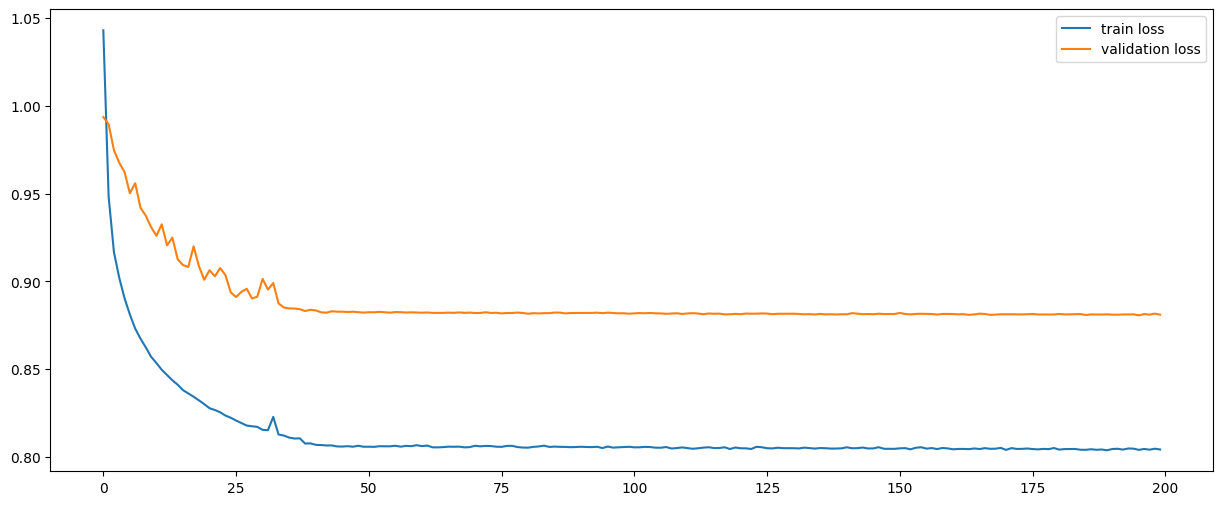

In [13]:
print("------- List Hyper Parameters -------")
print("epochs   ->   " + str(epochs))
print("learningRate   ->   " + str(lr))
print("horizon    ->     " + str(T))
print("batch size   ->    " + str(batch_size))
print("Optimizer   ->    " + str(optimizer))

train_losses, val_losses = batch_gd(model, criterion, optimizer, 
                                     epochs)

plt.figure(figsize=(15,6))
plt.plot(train_losses, label='train loss')
plt.plot(val_losses, label='validation loss')
plt.legend()

### **Model Testing**

In [15]:
model = torch.load('./best_model_CTABL')

n_correct = 0.
n_total = 0.
all_targets = []
all_predictions = []

for inputs, targets in test_loader:
    # Move to GPU
    inputs, targets = inputs.to(device, dtype=torch.float), targets.to(device, dtype=torch.int64)

    # Forward pass
    outputs = model(inputs)

    # Get prediction
    # torch.max returns both max and argmax
    _, predictions = torch.max(outputs, 1)

    # update counts
    n_correct += (predictions == targets).sum().item()
    n_total += targets.shape[0]

    all_targets.append(targets.cpu().numpy())
    all_predictions.append(predictions.cpu().numpy())

test_acc = n_correct / n_total
print(f"Test acc: {test_acc:.4f}")
  
all_targets = np.concatenate(all_targets)    
all_predictions = np.concatenate(all_predictions)    

Test acc: 0.7384


accuracy_score: 0.7383949617762747
              precision    recall  f1-score   support

           0     0.6316    0.7459    0.6840     38464
           1     0.7977    0.8317    0.8144     65997
           2     0.7687    0.5548    0.6445     35112

    accuracy                         0.7384    139573
   macro avg     0.7327    0.7108    0.7143    139573
weighted avg     0.7447    0.7384    0.7357    139573



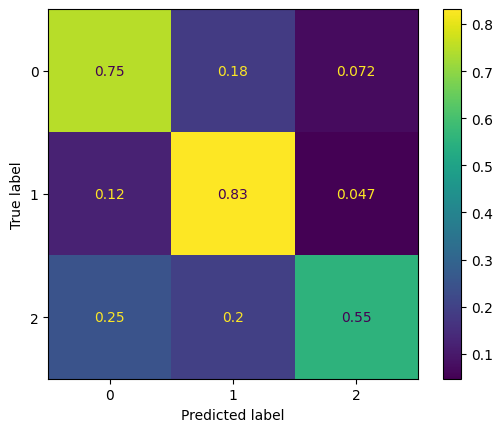

In [16]:
print('accuracy_score:', accuracy_score(all_targets, all_predictions))
print(classification_report(all_targets, all_predictions, digits=4))

c = confusion_matrix(all_targets, all_predictions, normalize="true")
disp = ConfusionMatrixDisplay(c)
disp.plot()
plt.show()